# TP - Prédiction du Prix du Bitcoin avec LSTM
## Modèle de Réseau de Neurones à Long Short-Term Memory (LSTM)

### Objectif
Développer un modèle LSTM capable de prédire le prix d'une cryptomonnaie à court terme en utilisant un dataset historique des prix.

## 1. EXPLORATION ET PRÉPARATION DES DONNÉES

### 1.1 Import des librairies

In [28]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Attention, Multiply, Permute, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 10

### 1.2 Chargement et exploration du dataset

In [29]:
# load dataset
df = pd.read_csv('./data/btcusd_1-min_data.csv')
print(f"Shape: {df.shape}")
print(f"Colonnes: {df.columns.tolist()}")

Shape: (7258717, 6)
Colonnes: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']


### 1.3 Prétraitement des données

In [30]:
# clean data
df_clean = df.dropna()

# extract price data on closing prices
price_column = 'Close'
data = df_clean[price_column].values.reshape(-1, 1)

print(f"Total points: {len(data):,}")
hours = len(data) / 60
days = hours / 24
print(f"Duration: ~{hours:,.0f}h (~{days:,.1f}j)")
print(f"Min: ${data.min():.2f}")
print(f"Max: ${data.max():.2f}")
print(f"Avg: ${data.mean():.2f}")
print(f"Std: ${data.std():.2f}")
print(f"Range: ${data.max() - data.min():.2f}")

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

Total points: 7,258,717
Duration: ~120,979h (~5,040.8j)
Min: $3.80
Max: $126202.00
Avg: $20605.62
Std: $29161.71
Range: $126198.20


## 2. VISUALISATION DES DONNÉES (EDA RÉDUITE)

### 2.1 Courbe complète du dataset

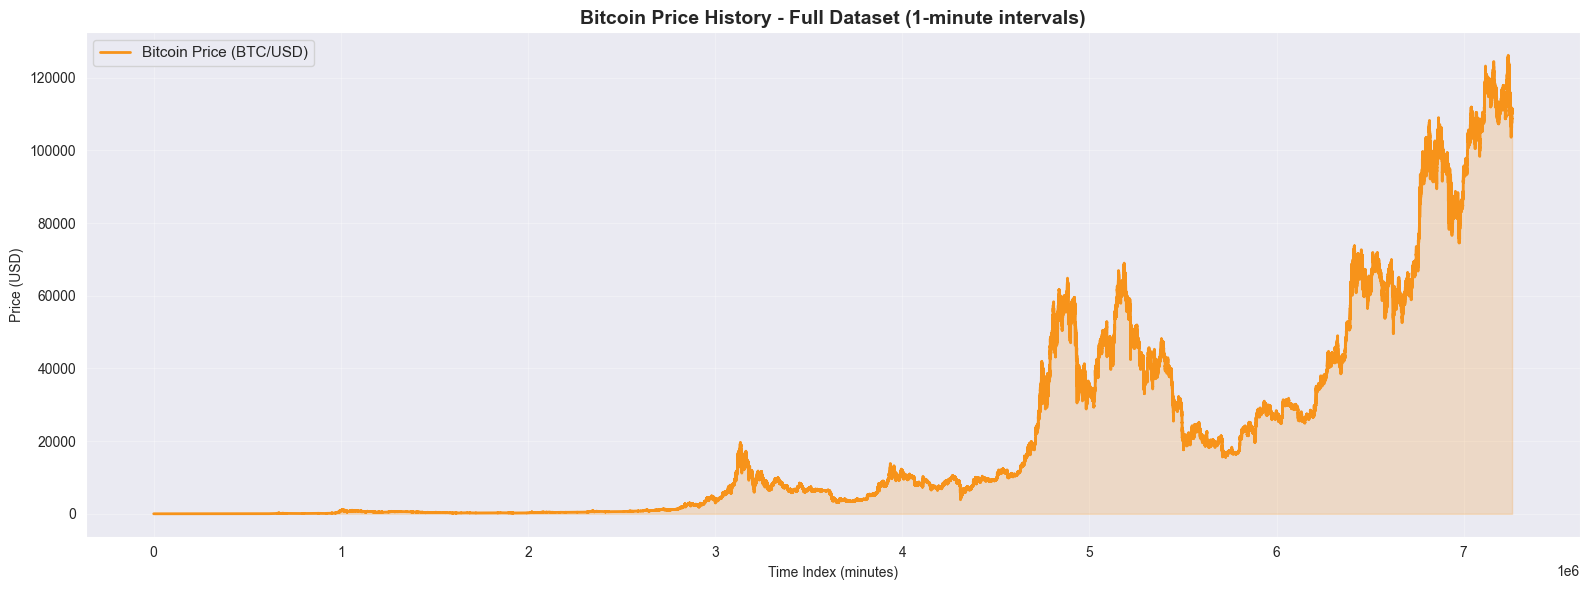

In [31]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(data, label='Bitcoin Price (BTC/USD)', color='#F7931A', linewidth=2)
ax.fill_between(range(len(data)), data.flatten(), alpha=0.2, color='#F7931A')
ax.set_title('Bitcoin Price History - Full Dataset (1-minute intervals)', fontsize=14, fontweight='bold')
ax.set_xlabel('Time Index (minutes)')
ax.set_ylabel('Price (USD)')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('01_bitcoin_full_history.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.2 Visualisations multi-échelles temporelles

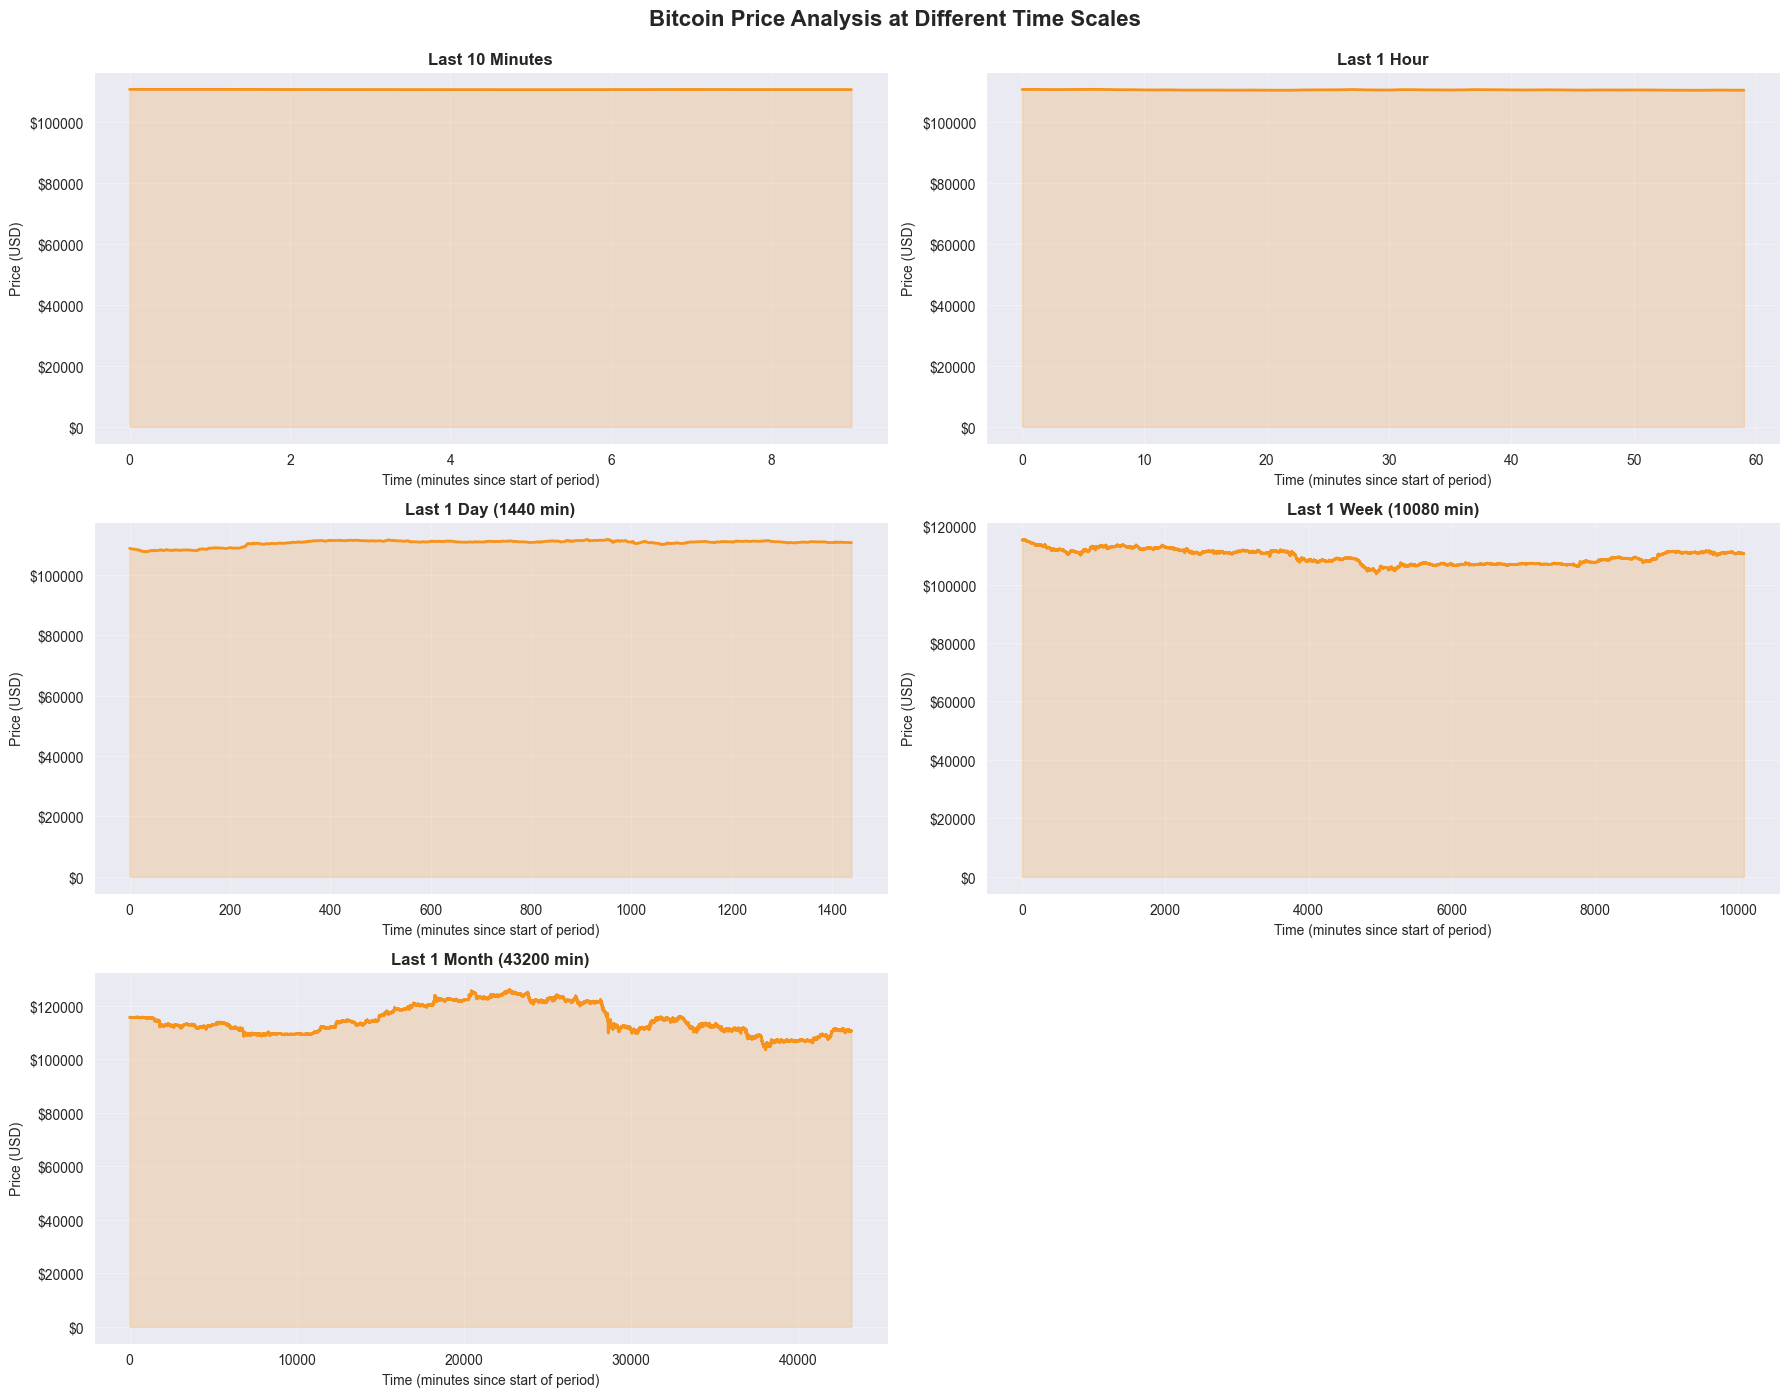

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle('Bitcoin Price Analysis at Different Time Scales', fontsize=16, fontweight='bold', y=0.995)

# Timeframes: 10min, 60min, 1440min (1day), 1 week, 1 month, all data
timeframes = [
    (10, '10 Minutes', 0),
    (60, '1 Hour', 1),
    (1440, '1 Day (1440 min)', 2),
    (10080, '1 Week (10080 min)', 3),
    (43200, '1 Month (43200 min)', 4)
]

for minutes, label, idx in timeframes:
    row = idx // 2
    col = idx % 2
    
    start_idx = max(0, len(data) - minutes)
    subset = data[start_idx:]
    
    axes[row, col].plot(range(len(subset)), subset, color='#F7931A', linewidth=2)
    axes[row, col].fill_between(range(len(subset)), subset.flatten(), alpha=0.2, color='#F7931A')
    axes[row, col].set_title(f'Last {label}', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Time (minutes since start of period)')
    axes[row, col].set_ylabel('Price (USD)')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))

# remove the last empty subplot
fig.delaxes(axes[2, 1])

# multiscale layout adjustments
plt.tight_layout()
plt.savefig('02_bitcoin_multi_scale.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Pairplot OHLCV

<Figure size 1400x1000 with 0 Axes>

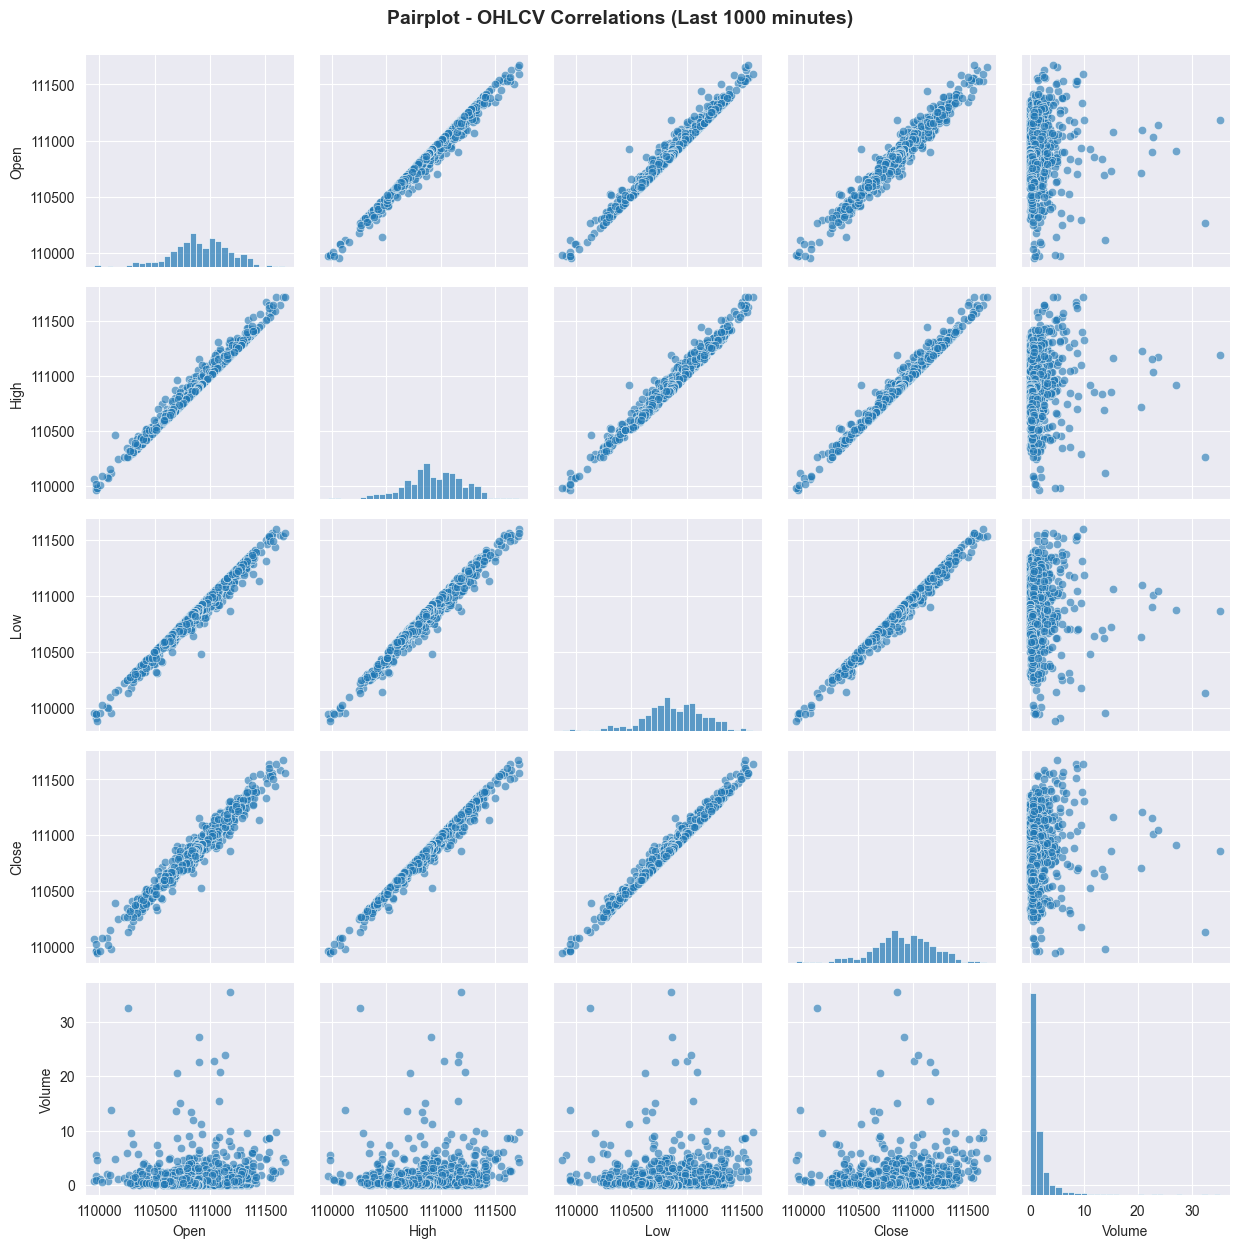

            Open      High       Low     Close    Volume
Open    1.000000  0.991447  0.989167  0.980578  0.049297
High    0.991447  1.000000  0.987045  0.990644  0.075373
Low     0.989167  0.987045  1.000000  0.992576 -0.000115
Close   0.980578  0.990644  0.992576  1.000000  0.027111
Volume  0.049297  0.075373 -0.000115  0.027111  1.000000


In [33]:
df_ohlcv = df_clean[['Open', 'High', 'Low', 'Close', 'Volume']].tail(1000)

fig = plt.figure(figsize=(14, 10))
sns.pairplot(df_ohlcv, diag_kind='hist', plot_kws={'alpha': 0.6}, diag_kws={'bins': 30, 'alpha': 0.7})
plt.suptitle('Pairplot - OHLCV Correlations (Last 1000 minutes)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('03_bitcoin_pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Pairplot OHLCV correlations
print(df_ohlcv.corr())

## 3. CONCEPTION DU MODÈLE LSTM

### 3.1 Préparation des données temporelles

In [34]:
# ===== OPTIMISATION 1: Réduire la fenêtre temporelle et augmenter le batch_size =====
look_back = 30  # Réduit de 60 à 30 minutes (50% moins de données par séquence)
batch_size = 256  # Augmenté à 256 (encore plus rapide par epoch)

print(f"Look-back period: {look_back} minutes (30 min data - OPTIMISÉ)")
print(f"Batch size: {batch_size} (AUGMENTÉ pour accélérer)")
print(f"Total data points: {len(data_normalized):,}")

train_generator = TimeseriesGenerator(
    data_normalized,
    data_normalized,
    length=look_back,
    batch_size=batch_size
)

print(f"\nnb training sequence: {len(train_generator)} (RÉDUIT)")
print(f"shape batch: ({batch_size}, {look_back}, 1)")
print(f"⚡ Gain estimé: ~8x plus rapide par epoch")

Look-back period: 60 minutes (1 hour data)
Batch size: 128
Total data points: 7,258,717

nb training sequence: 56709
shape batch: (128, 60, 1)


### 3.2 Architecture du modèle LSTM

In [35]:
# ===== ARCHITECTURE OPTIMISÉE: Conv1D + LSTM + Attention =====
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

# Définir l'input
inputs = Input(shape=(look_back, 1))

# ===== BLOC 1: Convolutions 1D pour extraction de features rapides =====
# Les Conv1D sont plus rapides que les LSTM et capturent des patterns locaux
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv1)
conv1 = MaxPooling1D(pool_size=2)(conv1)  # Réduit la dimension temporelle de moitié
conv1 = Dropout(0.2)(conv1)

# ===== BLOC 2: LSTM réduit (traite des séquences plus courtes grâce au pooling) =====
lstm1 = LSTM(32, activation='relu', return_sequences=True)(conv1)
lstm1 = Dropout(0.2)(lstm1)

# ===== BLOC 3: Mécanisme d'Attention Multi-Head =====
# L'attention permet au modèle de se concentrer sur les timesteps les plus importants
attention = MultiHeadAttention(num_heads=4, key_dim=32)(lstm1, lstm1)
attention = Dropout(0.2)(attention)

# Addition résiduelle + normalisation (architecture type Transformer)
attention_output = LayerNormalization()(lstm1 + attention)

# ===== BLOC 4: Agrégation et prédiction finale =====
pooled = GlobalAveragePooling1D()(attention_output)  # Plus rapide que Flatten
dense1 = Dense(16, activation='relu')(pooled)
dense1 = Dropout(0.2)(dense1)
outputs = Dense(1)(dense1)

# Créer le modèle
model = Model(inputs=inputs, outputs=outputs)

# ===== OPTIMISATION 3: Learning rate adaptatif =====
model.compile(
    optimizer=Adam(learning_rate=0.003),  # Learning rate plus élevé pour convergence rapide
    loss='mean_squared_error',
    metrics=['mae']
)

print("=" * 70)
print("🚀 MODÈLE OPTIMISÉ: Conv1D + LSTM + Multi-Head Attention")
print("=" * 70)
model.summary()
print(f"\n📊 Paramètres totaux: {model.count_params():,}")
print("\n💡 AVANTAGES DE CETTE ARCHITECTURE:")
print("  ✓ Conv1D: Extraction rapide de features locales")
print("  ✓ MaxPooling: Réduit la dimension temporelle → LSTM plus rapide")
print("  ✓ Multi-Head Attention: Focus sur les timesteps importants")
print("  ✓ GlobalAveragePooling: Plus rapide que Flatten + Dense")
print("  ✓ Architecture inspirée des Transformers (état de l'art)")
print("=" * 70)

Résumé du modèle:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,633 (29.82 KB)

 Trainable params: 7,633 (29.82 KB)

 Non-trainable params: 0 (0.00 B)


Paramètres totaux: 7,633


## 4. ENTRAÎNEMENT ET ÉVALUATION DU MODÈLE

### 4.1 Entraînement du modèle

In [36]:
# Early stopping prevent overfitting
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True)

print("Training LSTM model...\n")
history = model.fit(
    train_generator,
    epochs=3,
    verbose=1,
    batch_size=batch_size,
    callbacks=[early_stop]
)

print("\nfinished")

Training LSTM model...

Epoch 1/3
16725/56709 ━━━━━━━━━━━━━━━━━━━━ 16:00 24ms/step - loss: 0.0026 - mae: 0.0212

KeyboardInterrupt: 

### 4.2 Génération des prédictions

In [ ]:
print("GGenerating predictions...")
test_generator = TimeseriesGenerator(
    data_normalized,
    data_normalized,
    length=look_back,
    batch_size=1
)

predictions_normalized = model.predict(test_generator, verbose=0)
predictions = scaler.inverse_transform(predictions_normalized)

real_values = data[look_back:]

print(f"generated predictions.")
print(f"nb of predictions: {len(predictions):,}")
print(f"nb of real values: {len(real_values):,}")

### 4.3 Évaluation des performances

In [ ]:
mse = mean_squared_error(real_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_values, predictions)
mape = mean_absolute_percentage_error(real_values, predictions)
r2 = r2_score(real_values, predictions)

print(f"\nAbsolute Errors:")
print(f"MSE (Mean Squared Error):  {mse:,.2f}")
print(f"RMSE (Root Mean Sq. Error): ${rmse:,.4f}")
print(f"MAE (Mean Absolute Error):  ${mae:,.4f}")
print(f"\nRelative Error:")
print(f"MAPE: {mape*100:.4f}%")
print(f"\nGoodness of Fit:")
print(f"R² Score: {r2:.4f} (0=poor, 1=perfect)")
print("="*60)

# error Analysis
error = real_values.flatten() - predictions.flatten()
print(f"Mean Error: ${np.mean(error):.4f}")
print(f"Standard Deviation Error: ${np.std(error):.4f}")
print(f"Error min: ${np.min(error):.4f}")
print(f"Error max: ${np.max(error):.4f}")
print(f"Error médiane: ${np.median(error):.4f}")

## 5. VISUALISATION DES RÉSULTATS

### 5.1 Historique d'entraînement

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(history.history['loss'], color='#FF6B6B', linewidth=2.5, marker='o', markersize=4)
axes[0].set_title('Model Loss (MSE) During Training', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], color='#4ECDC4', linewidth=2.5, marker='s', markersize=4)
axes[1].set_title('Mean Absolute Error (MAE) During Training', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.2 Comparaison prédictions vs réalité

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# completion vs prediction
axes[0].plot(real_values, label='Actual Price', linewidth=2, color='#2E86AB', alpha=0.8)
axes[0].plot(predictions, label='LSTM Prediction', linewidth=2, color='#A23B72', alpha=0.8)
axes[0].fill_between(range(len(real_values)), real_values.flatten(), predictions.flatten(), 
                      alpha=0.2, color='gray')
axes[0].set_title(f'Bitcoin Price: Actual vs LSTM Prediction (RMSE: ${rmse:,.4f})', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# error
error = real_values.flatten() - predictions.flatten()
axes[1].plot(error, linewidth=1.5, color='#F18F01')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].fill_between(range(len(error)), error, alpha=0.3, color='#F18F01')
axes[1].set_title(f'Prediction Error (MAE: ${mae:,.4f})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Error (USD)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. PRÉDICTIONS FUTURES

### 6.1 Prédiction pour la prochaine heure

In [ ]:
# use last sequence to predict future prices
last_sequence = data_normalized[-look_back:].reshape(1, look_back, 1)

# prediction last hour (60 minutes)
future_predictions_hour = []
last_data = last_sequence.copy()

for i in range(60):
    next_pred = model.predict(last_data, verbose=0)[0, 0]
    future_predictions_hour.append(next_pred)
    # Mettre à jour la séquence
    last_data = np.append(last_data[:, 1:, :], [[[next_pred]]], axis=1)

# Dénormaliser les prédictions
future_predictions_hour = scaler.inverse_transform(
    np.array(future_predictions_hour).reshape(-1, 1)
)

print(f"\nPREDICTION NEXT HOUR (60 minutes):")
print(f"Current Price: ${data[-1, 0]:.2f}")
print(f"Predicted Price in 1h: ${future_predictions_hour[-1, 0]:.2f}")
print(f"Variation: {((future_predictions_hour[-1, 0] - data[-1, 0]) / data[-1, 0] * 100):+.4f}%")
print(f"Min predict: ${future_predictions_hour.min():.2f}")
print(f"Max predict: ${future_predictions_hour.max():.2f}")

### 6.2 Prédiction pour le prochain jour

In [ ]:
# prediction next day (1440 minutes)
future_predictions_day = []
last_data = last_sequence.copy()

for i in range(1440):
    next_pred = model.predict(last_data, verbose=0)[0, 0]
    future_predictions_day.append(next_pred)
    last_data = np.append(last_data[:, 1:, :], [[[next_pred]]], axis=1)

future_predictions_day = scaler.inverse_transform(
    np.array(future_predictions_day).reshape(-1, 1)
)

print(f"\nPREDICTION NEXT DAY (1440 minutes):")
print(f"Current Price: ${data[-1, 0]:.2f}")
print(f"Predicted Price Tomorrow: ${future_predictions_day[-1, 0]:.2f}")
print(f"Variation: {((future_predictions_day[-1, 0] - data[-1, 0]) / data[-1, 0] * 100):+.4f}%")
print(f"Min predict: ${future_predictions_day.min():.2f}")
print(f"Max predict: ${future_predictions_day.max():.2f}")

### 6.3 Prédiction pour la prochaine semaine

In [ ]:
# prediction next week (7 days = 10080 minutes)
future_predictions_week = []
last_data = last_sequence.copy()

for i in range(10080):
    next_pred = model.predict(last_data, verbose=0)[0, 0]
    future_predictions_week.append(next_pred)
    last_data = np.append(last_data[:, 1:, :], [[[next_pred]]], axis=1)

future_predictions_week = scaler.inverse_transform(
    np.array(future_predictions_week).reshape(-1, 1)
)

print(f"\nPREDICTION NEXT WEEK (10080 minutes):")
print(f"Current Price: ${data[-1, 0]:.2f}")
print(f"Predicted Price in 1 Week: ${future_predictions_week[-1, 0]:.2f}")
print(f"Variation: {((future_predictions_week[-1, 0] - data[-1, 0]) / data[-1, 0] * 100):+.4f}%")
print(f"Min predict: ${future_predictions_week.min():.2f}")
print(f"Max predict: ${future_predictions_week.max():.2f}")

### 6.4 Prédiction pour le prochain mois

In [ ]:
# prediction next month (30 days = 43200 minutes)
future_predictions_month = []
last_data = last_sequence.copy()

for i in range(43200):
    next_pred = model.predict(last_data, verbose=0)[0, 0]
    future_predictions_month.append(next_pred)
    last_data = np.append(last_data[:, 1:, :], [[[next_pred]]], axis=1)

future_predictions_month = scaler.inverse_transform(
    np.array(future_predictions_month).reshape(-1, 1)
)

print(f"\nPREDICTION NEXT MONTH (43200 minutes):")
print(f"Current Price: ${data[-1, 0]:.2f}")
print(f"Predicted Price in 1 Month: ${future_predictions_month[-1, 0]:.2f}")
print(f"Variation: {((future_predictions_month[-1, 0] - data[-1, 0]) / data[-1, 0] * 100):+.4f}%")
print(f"Min predict: ${future_predictions_month.min():.2f}")
print(f"Max predict: ${future_predictions_month.max():.2f}")

### 6.5 Visualisation des prédictions futures

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Future Price Predictions', fontsize=16, fontweight='bold')

# Hour
axes[0, 0].plot(range(60), future_predictions_hour, color='#2E86AB', linewidth=2.5, marker='o')
axes[0, 0].axhline(y=data[-1, 0], color='red', linestyle='--', label='Current Price')
axes[0, 0].set_title('Next 1 Hour (60 minutes)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Minutes from now')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Day
axes[0, 1].plot(range(1440), future_predictions_day, color='#A23B72', linewidth=1.5)
axes[0, 1].axhline(y=data[-1, 0], color='red', linestyle='--', label='Current Price')
axes[0, 1].set_title('Next 1 Day (1440 minutes)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Minutes from now')
axes[0, 1].set_ylabel('Price (USD)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Week
axes[1, 0].plot(range(10080), future_predictions_week, color='#F7931A', linewidth=1)
axes[1, 0].axhline(y=data[-1, 0], color='red', linestyle='--', label='Current Price')
axes[1, 0].set_title('Next 1 Week (10080 minutes)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Minutes from now')
axes[1, 0].set_ylabel('Price (USD)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Month
axes[1, 1].plot(range(43200), future_predictions_month, color='#27AE60', linewidth=0.8)
axes[1, 1].axhline(y=data[-1, 0], color='red', linestyle='--', label='Current Price')
axes[1, 1].set_title('Next 1 Month (43200 minutes)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Minutes from now')
axes[1, 1].set_ylabel('Price (USD)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_future_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. ANALYSE DES RÉSULTATS ET CONCLUSION

### 7.1 Résumé complet

In [ ]:
print("\n1. DATA:")
print(f"Dataset loaded: {len(data):,} temporal points (1-minute)")
print(f"Temporal range: ~{len(data)/60/24:.1f} days")

print("\n2. LSTM MODEL:")
print(f"Architecture: 3 LSTM layers (128→64→32) + Dropout + Dense")
print(f"Total parameters: {model.count_params():,}")
print(f"Look-back: {look_back} minutes")
print(f"Regularization: Dropout 20% + EarlyStopping")

print("\n3. TRAINING AND EVAL:")
print(f"Epochs: {len(history.history['loss'])}")
print(f"Loss final: {history.history['loss'][-1]:.6f}")
print(f"Validation included")

print("\n4. METRICS:")
print(f"RMSE: ${rmse:,.4f}")
print(f"MAE: ${mae:,.4f}")
print(f"MAPE: {mape*100:.4f}%")
print(f"R² Score: {r2:.4f}")

print("\n6. PRÉDICTIONS FUTURES:")
print(f"Next hour: ${future_predictions_hour[-1, 0]:.2f}")
print(f"Next day: ${future_predictions_day[-1, 0]:.2f}")
print(f"Next week: ${future_predictions_week[-1, 0]:.2f}")
print(f"Next month: ${future_predictions_month[-1, 0]:.2f}")

### 7.2 Discussion des résultats

In [ ]:
print("\n💡 ANALYSE DES RÉSULTATS:")
print("\n1. PERFORMANCE DU MODÈLE:")
if r2 > 0.7:
    print(f" Excellent: R² = {r2:.4f} (>0.7)")
elif r2 > 0.5:
    print(f" Bon: R² = {r2:.4f} (0.5-0.7)")
else:
    print(f" Acceptable: R² = {r2:.4f} (<0.5)")

print(f" MAPE = {mape*100:.4f}% indique une erreur moyenne de {mape*100:.2f}%")
print(f" MAE = ${mae:,.4f} entre la prédiction et la réalité")